# Attempt 3:
## Target: 
Achieve less than 10K parameters & greater than 99.4% accuracy.

## Results:
Parameters: 8786
Training Accuracy: 98.76% (max 98.85%)
Test Accuracy: 99.43% (max 99.46%)

## Analysis
Model was changed to add capacity (kernels/channels).
Used LR Scheduler to reduce the Learning Rate gradually.
Model is good for less than 10K parameters, can try for less than 8K parameters in next step.
Batch size of 64 used as the batch size - accuracy graph showed max accuracy at around 64 batch size.

# Import Libraries

In [ ]:
# importing all the Python Packages & torch Library.
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Define Data Transformations & Dataset for Train/Test

In [ ]:
train_transforms = transforms.Compose([
                        transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                        # transforms.RandomErasing(),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Train / Test Dataloaders

In [ ]:
# seed the model to obtain consistent results
torch.manual_seed(1)
# this is the batch size , in 1 pas no of images passed together.
batch_size = 64
use_cuda = torch.cuda.is_available()

print("CUDA Available?", use_cuda)

# kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

# dataloader arguments - something you'll fetch these from cmdprmt. 
# Used batch size 64 as that gets us max accuracy, as per batch size - accuracy graph
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)



# load the training data and perform standard normalization 
# parameter for normalization is mean and std dev.
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias = True), # output 26X26X4 : RF- 3X3
            nn.ReLU(),
            nn.BatchNorm2d(4), # Batch Normalization after each convolution.
            nn.Dropout2d(0.05), # dropout of 5% at each layer
            
            nn.Conv2d(4, 8, 3), # output 24X24X8 : RF - 5x5
            nn.ReLU(),
            nn.BatchNorm2d(8),  # Batch Normalization after each convolution.
            nn.Dropout2d(0.05),  # dropout of 5% at each layer

            nn.Conv2d(8, 16, 3), # output 22X22X16 : RF - 7X7
            nn.ReLU(),
            nn.BatchNorm2d(16),  # Batch Normalization after each convolution.
            nn.Dropout2d(0.05),  # dropout of 5% at each layer

            nn.MaxPool2d(2, 2)       # output 11X11X16 : RF - 9x9 
            )
        self.conv2 = nn.Sequential(
            
           
            nn.Conv2d(16, 16, 3), # output 9X9X16 : RF - 13x13
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.05), # 5% dropout

            nn.Conv2d(16, 16, 3, padding=1), # output 9X9X16 : RF - 17x17
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.05), # 5% dropout

            )
        self.conv3 = nn.Sequential(
           
            nn.Conv2d(16, 16, 3,padding=1), # output 9X9X16 : RF - 21 X 21
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.05), # 5% dropout

            nn.Conv2d(16, 10, 1), # output 7X7X10 : RF- 21 X 21
            nn.AvgPool2d(7) # output 1x1x10 : RF - 33 x 33?

            )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x= self.conv2(x)
        x= self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, -1)

# Print Summary of Model

In [ ]:
!pip install torchsummary
from torchsummary import summary
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
       BatchNorm2d-3            [-1, 4, 26, 26]               8
         Dropout2d-4            [-1, 4, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             296
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
         Dropout2d-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
        Dropout2d-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [-1, 1

# Define Train and Test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Function to train 
'''
Args: 
Model : created model to be used for training
device : GPU or cpu
train_laoded: data on which the training has to be done
Optimizer : the optimization algorithm to be used
epoch : no fo epoch 

'''
def train(model, device, train_loader, optimizer, epoch):
    model.train() # Set the model on training mode
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device) # moving the data to device
        optimizer.zero_grad() # zero the graidents 
        output = model(data) # getting the model output
        loss = F.nll_loss(output, target) # calculating the The negative log likelihood loss
        train_losses.append(loss)
        loss.backward() # flowing the gradients backward.
        optimizer.step() # paameter updated basd on the current gradient.
        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)        
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

# Function to test 
'''
Args: 
Model : created model to be used for training
device : GPU or cpu
test_laoded: data on which the testing has to be done
 

'''
def test(model, device, test_loader):
    model.eval() # seting up the model for evalaution.
    test_loss = 0 # setting the test loss to 0
    correct = 0 # countign the no of coorect classfication.
    with torch.no_grad(): # turn off gradients, since we are in test mode
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)   # copy the data to device.
            output = model(data) # predict the output
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) # calculating hte test loss.
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

# Run the model

In [ ]:
from torch.optim.lr_scheduler import StepLR


model = Net().to(device) # move the model to device.
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)  # intiating the SGD optimizer
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(1, 16):
    print("epoch =", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)
    

  0%|          | 0/938 [00:00<?, ?it/s]

epoch = 1


loss=0.04308328777551651 batch_id=937 Train Accuracy=92.11: 100%|██████████| 938/938 [00:28<00:00, 32.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Test Accuracy: 9848/10000 (98.48%)

epoch = 2


loss=0.015669340267777443 batch_id=937 Train Accuracy=96.99: 100%|██████████| 938/938 [00:27<00:00, 33.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Test Accuracy: 9872/10000 (98.72%)

epoch = 3


loss=0.03179297596216202 batch_id=937 Train Accuracy=97.52: 100%|██████████| 938/938 [00:28<00:00, 32.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Test Accuracy: 9890/10000 (98.90%)

epoch = 4


loss=0.026832295581698418 batch_id=937 Train Accuracy=97.89: 100%|██████████| 938/938 [00:28<00:00, 33.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test Accuracy: 9913/10000 (99.13%)

epoch = 5


loss=0.014714506454765797 batch_id=937 Train Accuracy=97.96: 100%|██████████| 938/938 [00:28<00:00, 32.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9925/10000 (99.25%)

epoch = 6


loss=0.17991861701011658 batch_id=937 Train Accuracy=98.06: 100%|██████████| 938/938 [00:28<00:00, 32.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Test Accuracy: 9927/10000 (99.27%)

epoch = 7


loss=0.027076590806245804 batch_id=937 Train Accuracy=98.52: 100%|██████████| 938/938 [00:28<00:00, 32.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Test Accuracy: 9940/10000 (99.40%)

epoch = 8


loss=0.014615360647439957 batch_id=937 Train Accuracy=98.66: 100%|██████████| 938/938 [00:28<00:00, 32.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Test Accuracy: 9942/10000 (99.42%)

epoch = 9


loss=0.11603250354528427 batch_id=937 Train Accuracy=98.65: 100%|██████████| 938/938 [00:28<00:00, 32.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Test Accuracy: 9939/10000 (99.39%)

epoch = 10


loss=0.05683312565088272 batch_id=937 Train Accuracy=98.70: 100%|██████████| 938/938 [00:28<00:00, 32.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Test Accuracy: 9940/10000 (99.40%)

epoch = 11


loss=0.3108772039413452 batch_id=937 Train Accuracy=98.70: 100%|██████████| 938/938 [00:28<00:00, 32.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Test Accuracy: 9946/10000 (99.46%)

epoch = 12


loss=0.01309967041015625 batch_id=937 Train Accuracy=98.78: 100%|██████████| 938/938 [00:28<00:00, 32.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Test Accuracy: 9944/10000 (99.44%)

epoch = 13


loss=0.02326037921011448 batch_id=937 Train Accuracy=98.81: 100%|██████████| 938/938 [00:28<00:00, 32.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Test Accuracy: 9943/10000 (99.43%)

epoch = 14


loss=0.038820069283246994 batch_id=937 Train Accuracy=98.85: 100%|██████████| 938/938 [00:28<00:00, 32.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Test Accuracy: 9942/10000 (99.42%)

epoch = 15


loss=0.004630223847925663 batch_id=937 Train Accuracy=98.76: 100%|██████████| 938/938 [00:28<00:00, 32.63it/s]



Test set: Average loss: 0.0170, Test Accuracy: 9943/10000 (99.43%)



Text(0.5, 1.0, 'Test Accuracy')

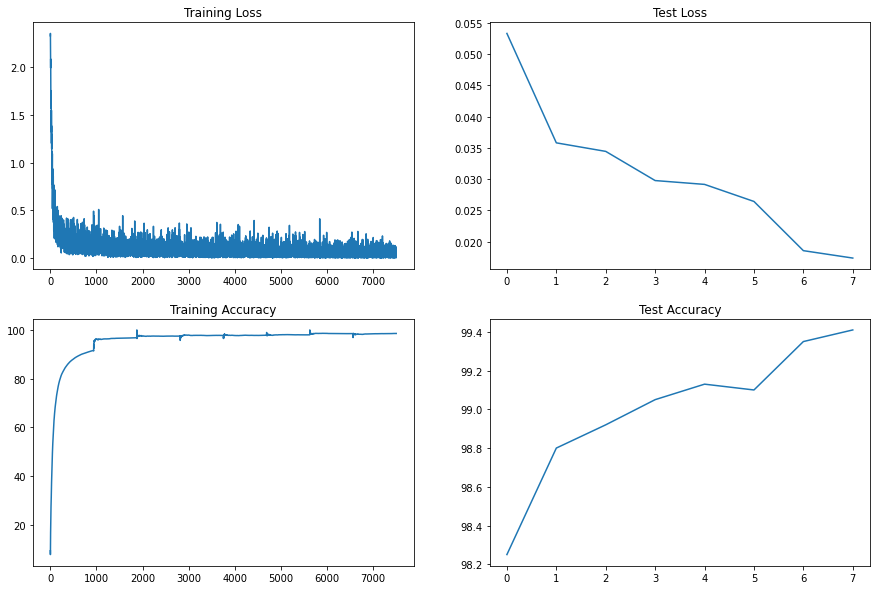

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")